In [3]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorEstimator

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit_aer.primitives import SamplerV2

from qiskit.aqua.components.optimizers import SPSA

ModuleNotFoundError: No module named 'qiskit.aqua'

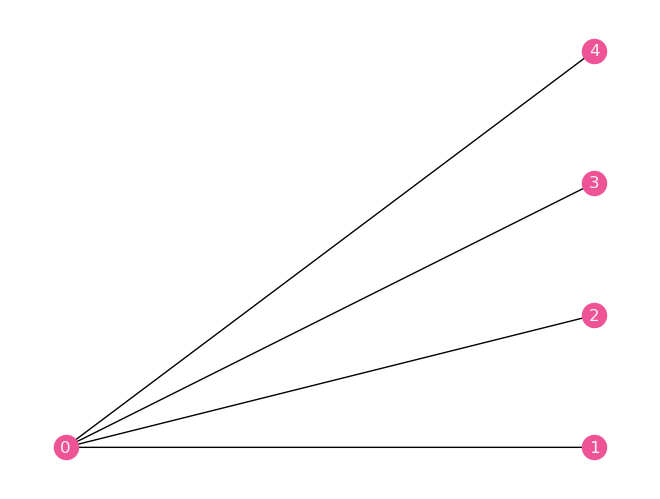

In [6]:
num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

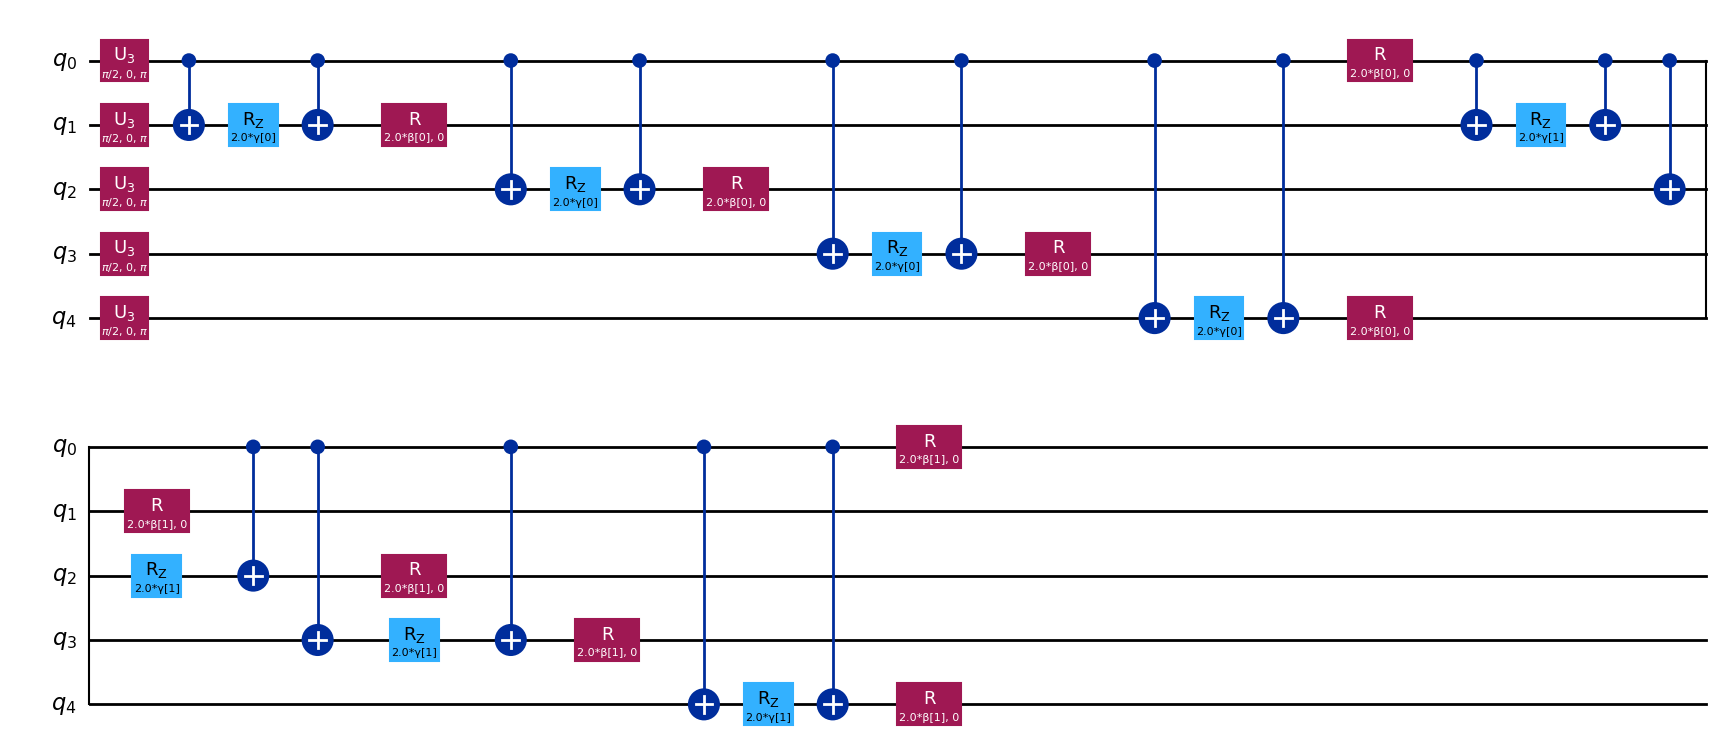

In [7]:
# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

In [8]:
# Optimization for real quantum hardware
# Optimizes for the native gates of the QC in question
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile

# not really needed on a simulator
# target = backend.target
# pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = ansatz
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

# ansatz_isa = pm.run(ansatz)
# ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

# Hamiltonian also has to be optimized
# hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
# hamiltonian_isa

# ... (inside the cost_func) ...

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    # Transpile the ansatz circuit to the basis gates supported by the backend
    transpiled_ansatz = edgestranspile(ansatz, basis_gates=['u1', 'u2', 'u3', 'cx', 'id'])

    pub = (transpiled_ansatz, [hamiltonian], [params])  # Use the transpiled circuit
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [9]:
# session = Session(backend=backend)

# Configure estimator
# estimator = Estimator(session=session) # This is the hardware version
estimator = EstimatorV2()
# estimator = StatevectorEstimator() # alternate gpu bound option, though density matrices might be better
estimator.options.default_shots = 10_000
# estimator.options.dynamical_decoupling.enable = True

# Configure sampler
# sampler = Sampler(session=session)
sampler = Sampler
# sampler.options.default_shots = 10_000
# sampler.options.dynamical_decoupling.enable = True

In [10]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

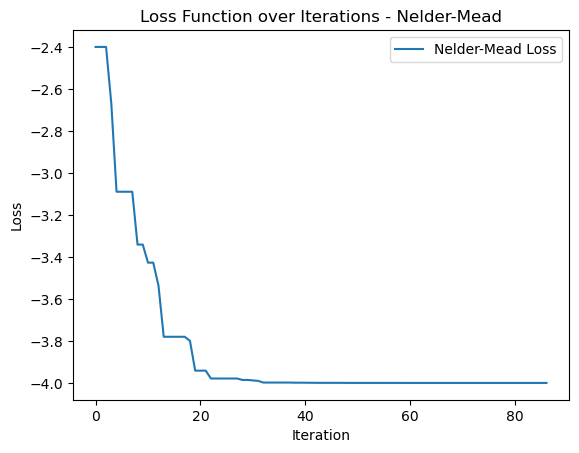

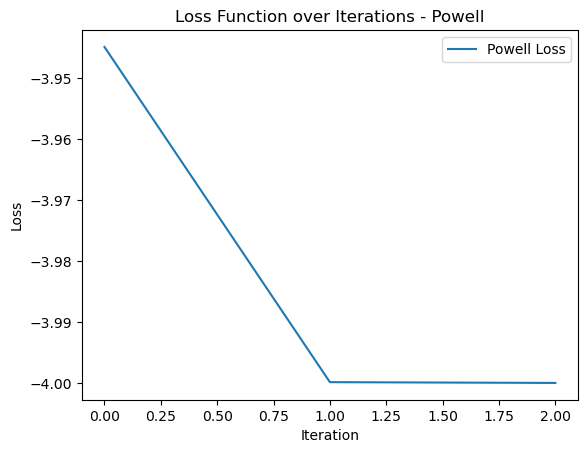

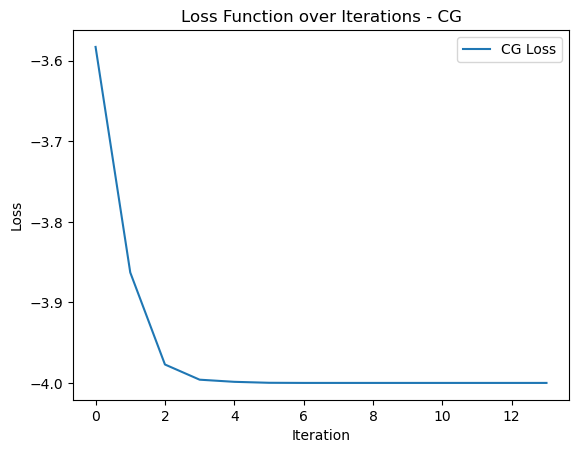

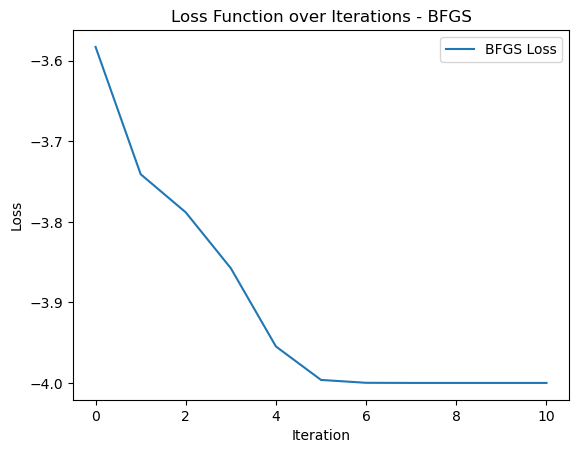

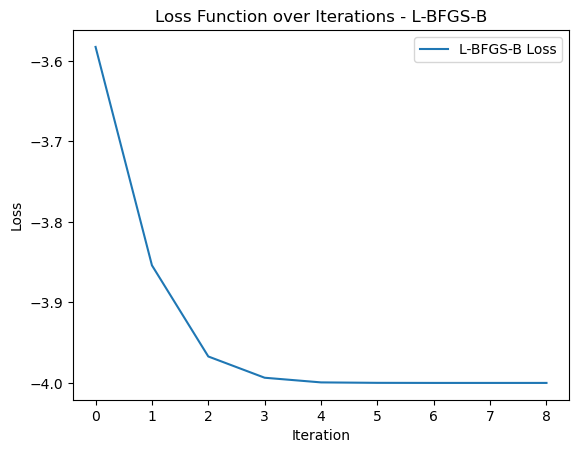

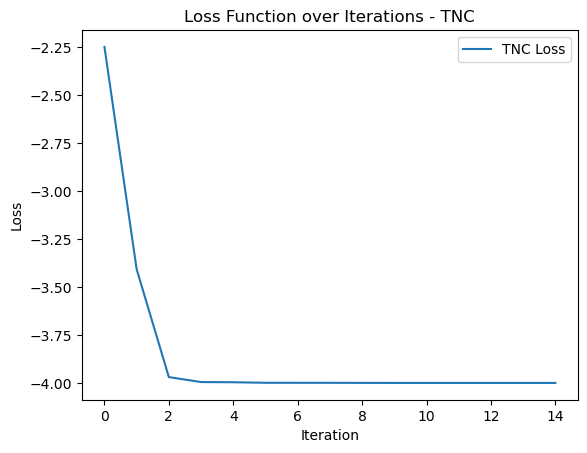

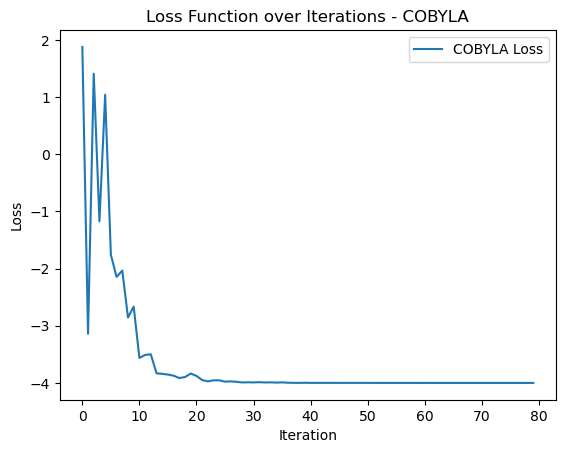

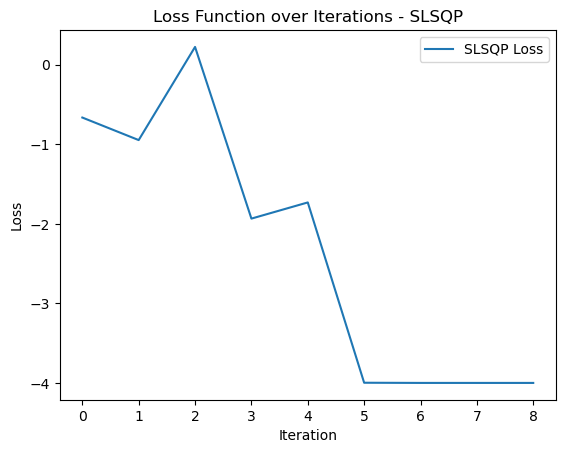

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# List of optimization methods to test
methods = ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYLA", "SLSQP"]

# Generate random initial values for x0
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

# Loop through each method to perform optimization and plot the results
for method in methods:
    # List to store loss values for the current method
    loss_values = []

    # Define the callback function to store the loss at each step
    def callback(x):
        # Compute the loss function value at each step
        loss_value = cost_func(x, ansatz_isa, hamiltonian_isa, estimator)
        loss_values.append(loss_value)

    # Perform the optimization
    try:
        res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method=method, callback=callback)

        # Plot the loss values for this method
        plt.plot(loss_values, label=f"{method} Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"Loss Function over Iterations - {method}")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Optimization with method {method} failed: {e}")